In [1]:
# 25.01.22 Works - JBK

# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

# Add mavenn to the path
import sys
sys.path.insert(0, '../../../')# Load mavenn

# Load mavenn
import mavenn
print(mavenn.__path__)

['/Users/jkinney/github/mavenn/mavenn/examples/models/../../../mavenn']


In [2]:
# Load example data
data_df = mavenn.load_example_dataset('mpsa')

# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')
data_df.head(10)

test N: 6,078
training + validation N: 24,405


,set,tot_ct,ex_ct,y,x
0,training,28,2,0.023406,GGAGUGAUG
1,training,193,15,-0.074999,UUCGCGCCA
2,training,27,0,-0.438475,UAAGCUUUU
3,training,130,2,-0.631467,AUGGUCGGG
4,training,552,19,-0.433012,AGGGCAGGA
5,training,216,6,-0.482679,GGUGUCUGU
6,validation,88,4,-0.241737,CAGGCAAAC
7,training,14,0,-0.167408,CAUGCAGCU
8,training,170,14,-0.048222,CAAGUCACU
9,training,242,13,-0.230795,UCCGCGCUA


In [3]:
# Get sequence length
L = len(data_df['x'][0])

# Define model
model = mavenn.Model(L=L,
                     alphabet='rna',
                     gpmap_type='pairwise', 
                     regression_type='GE',
                     theta_regularization=0.1,
                     ge_noise_model_type='SkewedT',
                     ge_heteroskedasticity_order=2)

In [4]:
# Set training data
model.set_data(x=data_df['x'],
               y=data_df['y'],
               validation_flags=(data_df['set']=='validation'),
               shuffle=True)

N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.201 sec.


In [5]:
# Fit model to data
model.fit(learning_rate=.001,
          epochs=1000,
          batch_size=200,
          early_stopping=True,
          early_stopping_patience=30,
          linear_initialization=False)

Epoch 1/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 287.6559 - val_loss: 254.9832 - I_var: -0.4831 - val_I_var: -0.4904
Epoch 2/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 253.0400 - val_loss: 231.4484 - I_var: -0.3151 - val_I_var: -0.3053
Epoch 3/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 230.9948 - val_loss: 213.5320 - I_var: -0.1826 - val_I_var: -0.1679
Epoch 4/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 215.1719 - val_loss: 199.6885 - I_var: -0.0930 - val_I_var: -0.0826
Epoch 5/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 201.9133 - val_loss: 188.2909 - I_var: -0.0104 - val_I_var: 0.0168
Epoch 6/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 190.4543 - val_loss: 179.5637 - I_var: 0.0662 - val_I_var: 0.0563
Epoch 7/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 183.1194 - val_loss: 172.5681 - I_var: 0.0981 - val_I_var: 0.1040
Epoch 8/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 177.6677 - val_loss: 167.4883 - I_var: 0.1582 - v

In [6]:
# Save model
model.save('mpsa_ge_pairwise')

Model saved to these files:
	mpsa_ge_pairwise.pickle
	mpsa_ge_pairwise.weights.h5


In [7]:
# Load model
model = mavenn.load('mpsa_ge_pairwise')

Model loaded from these files:
	mpsa_ge_pairwise.pickle
	mpsa_ge_pairwise.weights.h5


In [8]:
# Get x and y
x_test = test_df['x'].values
y_test = test_df['y'].values

On test data:
I_var_test: 0.335 +- 0.029 bits
I_pred_test: 0.352 +- 0.013 bits


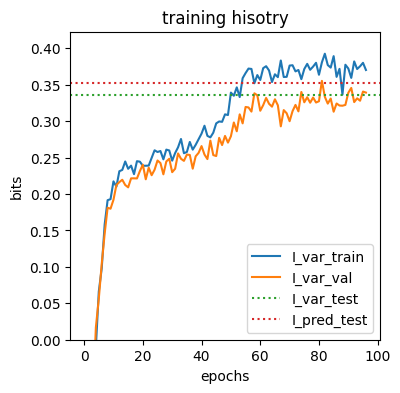

In [9]:
# Show training history
print('On test data:')

# Compute likelihood information
I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.axhline(I_var, color='C2', linestyle=':', label='I_var_test')
ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
ax.set_ylim([0, I_pred*1.2]);

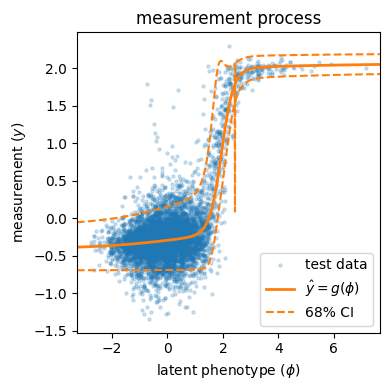

In [13]:
# Predict latent phentoype values (phi) on test data
phi_test = model.x_to_phi(x_test)

# Predict measurement values (yhat) on test data
yhat_test = model.x_to_yhat(x_test)

# Set phi lims and create grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 90% CI for each yhat
q = [0.05, 0.95] #[0.16, 0.84]
yqs_grid = model.yhat_to_yq(yhat_grid, q=q)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi_test, y_test, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label=r'$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1', label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel(r'latent phenotype $(\phi)$')
ax.set_ylabel(r'measurement $(y)$')
ax.set_title(r'measurement process')
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

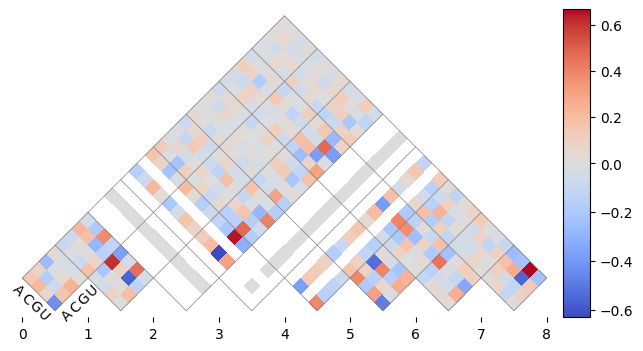

In [14]:
# Plot pairwise parameters
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[8, 4])
mavenn.heatmap_pairwise(values=theta['theta_lclc'],
                        alphabet=theta['alphabet'],
                        ax=ax);

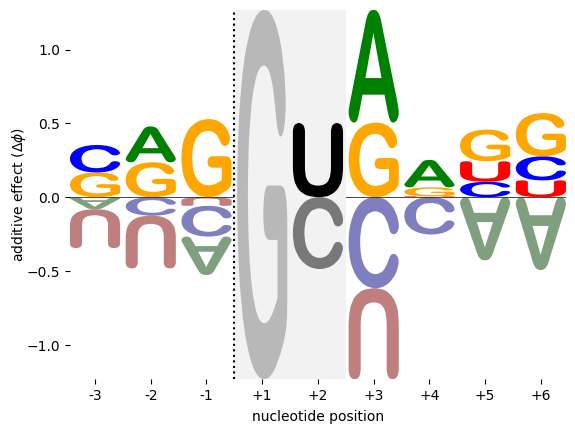

In [23]:
import logomaker
fig, ax = plt.subplots()
logo_df = model.get_theta()['logomaker_df'].fillna(0)
logo = logomaker.Logo(df=logo_df, ax=ax, fade_below=.5, shade_below=.5, width=.9, font_name='Arial Rounded MT Bold')


# Style logo
ylim = ax.get_ylim()
logo.highlight_position_range(pmin=3, pmax=4, color='w', alpha=1, zorder=10)
logo.highlight_position_range(pmin=3, pmax=4, color='gray', alpha=.1, zorder=11)
logo.style_single_glyph(p=3, c='G', floor=ylim[0], ceiling=ylim[1], color='gray', zorder=30, alpha=.5, flip=False)
logo.style_single_glyph(p=4, c='U', color='k', zorder=30)
logo.style_single_glyph(p=4, c='C', color='k', zorder=30)
logo.style_spines(visible=False)

# Sytle axes
ax.axvline(2.5, linestyle=':', color='k', zorder=30)
ax.set_ylabel(r'additive effect $(\Delta \phi)$', labelpad=-1)
ax.set_xticks([0,1,2,3,4,5,6,7,8])
ax.set_xticklabels([f'{x:+d}' for x in range(-3,7) if x!=0])
ax.set_xlabel(r'nucleotide position', labelpad=5);

